## Modelo de Ising

![image.png](attachment:image.png)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

In [5]:
# Genera una configuracion de spines aleatorios
def initial_state(rng, n):

    return 2*rng.integers(0,2, size= ((n,n))) -1



# Monte Carlo usando el algoritmo de metrópolis
def mc_single_step( rng, grid, beta):

    n = grid.shape[0]

    # Random site
    ii = rng.integers(0, n)
    jj = rng.integers(0, n)

    # Compute the energy change
    DeltaE = 2*grid[ii, jj]*(grid[(ii+1)%n, jj] + grid[(ii-1+n)%n, jj] + grid[ii, (jj+1)%n] + grid[ii, (jj-1+n)%n])

    # Select or reject
    if DeltaE < 0:
        grid[ii, jj] *= -1

    elif rng.random() < np.exp(-beta*DeltaE):
        grid[ii, jj] *= -1




# Perform a full (on average on every site) monte carlo step
def mc_full_step(rng, grid, beta):

    n = grid.shape[0]
    n2 = n*n
    for istep in range(0, n2):
        mc_single_step( rng, grid, beta)


# Energía para esta configuración


@njit
def compute_energy(grid):

    n = grid.shape[0]
    energy = 0.0
    for ii in range(n):
        for jj in range(n):
            neigh_sum = grid[(ii+1)%n, jj] + grid[(ii-1+n)%n, jj] + grid[ii, (jj+1)%n] + grid[ii, (jj-1+n)%n]
            energy -= grid[ii,jj]*neigh_sum

    return energy/2.0



@njit
def compute_magnetization(grid):
    return np.abs(np.sum(grid))

In [6]:
# Constantes

N= 15
NTEMP = 20 # Numero de puntos de temperatura
TEMP = np.linspace(1.53, 3.28, NTEMP)
BETA = 1.0/TEMP
NEQ = 300 # Pasos de Equilibrio
NSAMPLE = 1000

NCOLS = 5
NROWS = int(NTEMP/NCOLS)

# Observables
E0, M0, C0, X0 = np.zeros(NTEMP), np.zeros(NTEMP), np.zeros(NTEMP), np.zeros(NTEMP)


T:  1.53 1.62 1.71 1.81 1.90 1.99 2.08 2.17 2.27 2.36 2.45 2.54 2.64 2.73 2.82 2.91 3.00 3.10 3.19 3.28 


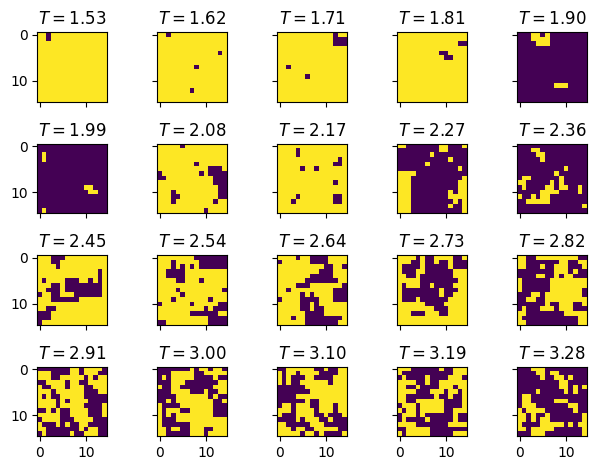

In [7]:
fig, ax = plt.subplots(NROWS, NCOLS, sharex = True, sharey = True)
TEMP = np.linspace(1.53, 3.28, NTEMP)
BETA = 1.0/TEMP
print("T: ", end=" ")


for itemp in range(NTEMP):
    print(f"{TEMP[itemp]:.2f}", end=" ")
    SEED = 43
    rng = np.random.default_rng(seed= SEED)
    e1=m1=e2=m2= 0.0

    # Create the grid
    grid = initial_state( rng, N)

    #equilibrium/thermalization
    for ieq in range(NEQ):
        mc_full_step(rng, grid, BETA[itemp])

    # Sampling( what about correlation?)
    for isample in range(NSAMPLE):
        mc_full_step(rng, grid, BETA[itemp])
        energy = compute_energy(grid)
        magnetization =  compute_magnetization(grid)
        e1 += energy
        e2 += energy*energy
        m1 += magnetization
        m2 += magnetization*magnetization
    ax[itemp//NCOLS, itemp%NCOLS].imshow(grid)
    ax[itemp//NCOLS, itemp%NCOLS].set_title(rf"$T = {TEMP[itemp]:.2f}$")


    # Compute averages and also normalize by size

    n1 = 1.0/(NSAMPLE*N*N)
    n2= n1/NSAMPLE
    E0[itemp] = e1*n1
    M0[itemp] = m1*n1
    C0[itemp] = (n1*e2 - n2*e1*e1)*BETA[itemp]*BETA[itemp]
    X0[itemp] = (n1*m2 -n2*m1*m1)*BETA[itemp]


print()
plt.tight_layout()
plt.savefig('T43.pdf', bbox_inches='tight')

Text(0.5, 1.0, 'Susceptibility')

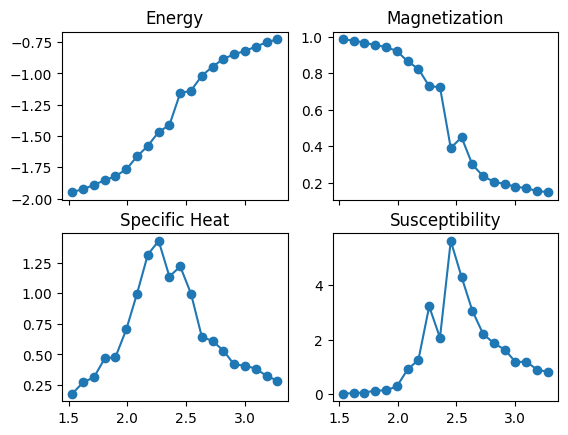

In [8]:
# Plot Observables

fig, ax = plt.subplots(2,2, sharex =  True)
ax[0,0].plot(TEMP, E0, "-o")
ax[0,0].set_title("Energy")
ax[0,1].plot(TEMP, M0, "-o")
ax[0,1].set_title("Magnetization")
ax[1,0].plot(TEMP, C0, "-o")
ax[1,0].set_title("Specific Heat")
ax[1,1].plot(TEMP, X0, "-o")
ax[1,1].set_title("Susceptibility")

# Diferentes Seeds

In [1]:
def Termalization(N, NTEMP, MC_STEPS, SEEDS):
    # Constantes
    BETA = 1.0/ TEMP
    NSTEPS = N*N*MC_STEPS

    # Observables

    fig, ax = plt.subplots(2,1, figsize=(9.6, 7.2), sharex = True)
    for iseed in range(len(SEEDS)):
      SEED = SEEDS[iseed]
      rng = np.random.default_rng(seed= SEED)

      grid = initial_state(rng, N)

      E2 = np.zeros(NSTEPS)
      M2 = np.zeros(NSTEPS)
      for istep in range(NSTEPS):
          mc_single_step(rng,grid, BETA)
          energy = compute_energy(grid)
          magnetization = compute_magnetization(grid)
          E2[istep] = energy/(N*N)
          M2[istep] = magnetization/(N*N)


      ax[0].plot(np.arange(NSTEPS)/(N*N), E2, "-o",label=f'{SEED=}', ms=0.5)
      ax[1].plot(np.arange(NSTEPS)/(N*N), M2, "-o",label=f'{SEED=}', ms=0.5)
    ax[0].set_title("Energy")
    ax[1].set_xlabel('Mc steps per site', size=13)
    ax[1].set_title("Magnetization")
    ax[0].legend()
    ax[1].legend()
    plt.savefig(f'EM_{N}.png', bbox_inches = 'tight')

In [2]:
def Simul(N, NTEMP, SEEDS):
  # Constantes
  TEMP = np.linspace(1.53, 3.28, NTEMP)
  BETA = 1.0/TEMP
  NEQ = 300 # Pasos de Equilibrio
  NSAMPLE = 1000
  NSEED =len(SEEDS)


  # Observables
  E, M, C, X = np.zeros((NTEMP, NSEED)), np.zeros((NTEMP, NSEED)), np.zeros((NTEMP, NSEED)), np.zeros((NTEMP, NSEED))


  for itemp in range(NTEMP):
    print(f"T={TEMP[itemp]:.2f} -> ", end=" ")
    print("SEED: ", end="")

    for iseed, SEED in enumerate(SEEDS):
        print(f"{SEED}", end=" ")
        rng = np.random.default_rng(seed= SEED)
        e1=m1=e2=m2= 0.0

        # Create the grid
        grid = initial_state( rng, N)

        #equilibrium/thermalization
        for ieq in range(NEQ):
            mc_full_step(rng, grid, BETA[itemp])

        # Sampling
        for isample in range(NSAMPLE):
            mc_full_step(rng, grid, BETA[itemp])
            energy = compute_energy(grid)
            magnetization =  compute_magnetization(grid)
            e1 += energy
            e2 += energy*energy
            m1 += magnetization
            m2 += magnetization*magnetization


        # Compute averages and also normalize by size

        n1 = 1.0/(NSAMPLE*N*N)
        n2= n1/NSAMPLE
        E[itemp, iseed] = e1*n1
        M[itemp, iseed] = m1*n1
        C[itemp, iseed] = (n1*e2 - n2*e1*e1)*BETA[itemp]*BETA[itemp]
        X[itemp, iseed] = (n1*m2 -n2*m1*m1)*BETA[itemp]
    print()
  return E, M, C, X


In [11]:
def Plot_obs(N, E, M, C, X, NSEED):
  fig, ax = plt.subplots(2,2, figsize=(5*2, 5),sharex = True)
  T_c = 2/np.log(1+np.sqrt(2))
  TEMP = np.linspace(1.53, 3.28, NTEMP)
  for ii in range(NSEED):
      ax[0,0].plot(TEMP, E[:,ii], "-o", alpha=0.2)
  ax[0,0].errorbar(TEMP, E.mean(axis=1), yerr=E.std(axis=1), fmt= "b-s", label=f"{N=}")
  ax[0,0].vlines(x=T_c, ymin=np.min(E.mean(axis=1))*.97, ymax=np.max(E.mean(axis=1))*.97, linestyles='dashed', color='ORANGE', linewidth=2, label='$T_{cT} \\approx$ '+f'{T_c:.2f}')
  ax[0,0].set_title("Energy")

  for ii in range(NSEED):
      ax[0,1].plot(TEMP, M[:,ii], "-o", alpha=0.2)
  ax[0,1].errorbar(TEMP, M.mean(axis=1), yerr=M.std(axis=1), fmt= "b-s", label=f"{N=}")
  ax[0,1].vlines(x=T_c, ymin=np.min(M.mean(axis=1))*.97, ymax=np.max(M.mean(axis=1))*.97, linestyles='dashed', color='ORANGE', linewidth=2,label='$T_{cT} \\approx$ '+f'{T_c:.2f}')
  ax[0,1].set_title("Magnetization")


  for ii in range(NSEED):
      ax[1,0].plot(TEMP, C[:,ii], "-o", alpha=0.2)
  ax[1,0].errorbar(TEMP, C.mean(axis=1), yerr=C.std(axis=1), fmt= "b-s", label=f"{N=}")
  ax[1,0].vlines(x=T_c, ymin=np.min(C.mean(axis=1))*.97, ymax=np.max(C.mean(axis=1))*.97, linestyles='dashed', color='ORANGE', linewidth=2,label='$T_{cT} \\approx$ '+f'{T_c:.2f}')
  ax[1,0].set_title("Specific Heat")


  for ii in range(NSEED):
      ax[1,1].plot(TEMP, X[:,ii], "-o", alpha=0.2)
  ax[1,1].errorbar(TEMP, X.mean(axis=1), yerr=X.std(axis=1), fmt= "b-s", label=f"{N=}")
  ax[1,1].vlines(x=T_c, ymin=np.min(X.mean(axis=1))*.97, ymax=np.max(X.mean(axis=1))*.97, linestyles='dashed', color='ORANGE', linewidth=2,label='$T_{cT} \\approx$ '+f'{T_c:.2f}')
  ax[1,1].set_title("Susceptibility")
  ax[0,0].legend()
  ax[1,1].set_xlabel('T', size=13)
  ax[1,0].set_xlabel('T', size=13)
  plt.savefig(f'EMSS_{N}.pdf', bbox_inches = 'tight')

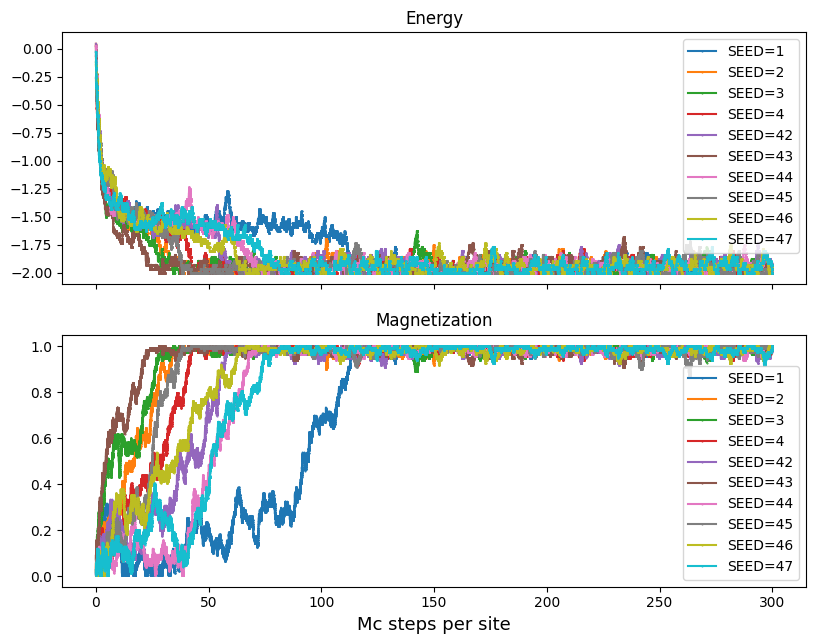

In [9]:
N = 15
TEMP = 1.53
SEEDS = [1,2,3,4,42,43,44,45,46,47]
Termalization(N,TEMP, 300, SEEDS)

In [10]:
N = 15
NTEMP = 20
SEEDS = [1,2,3,4,42,43,44,45,46,47]
E15, M15, C15, X15 = Simul(N, NTEMP, SEEDS)

T=1.53 ->  SEED: 1 2 3 4 42 43 44 45 46 47 
T=1.62 ->  SEED: 1 2 3 4 42 43 44 45 46 47 
T=1.71 ->  SEED: 1 2 3 4 42 43 44 45 46 47 
T=1.81 ->  SEED: 1 2 3 4 42 43 44 45 46 47 
T=1.90 ->  SEED: 1 2 3 4 42 43 44 45 46 47 
T=1.99 ->  SEED: 1 2 3 4 42 43 44 45 46 47 
T=2.08 ->  SEED: 1 2 3 4 42 43 44 45 46 47 
T=2.17 ->  SEED: 1 2 3 4 42 43 44 45 46 47 
T=2.27 ->  SEED: 1 2 3 4 42 43 44 45 46 47 
T=2.36 ->  SEED: 1 2 3 4 42 43 44 45 46 47 
T=2.45 ->  SEED: 1 2 3 4 42 43 44 45 46 47 
T=2.54 ->  SEED: 1 2 3 4 42 43 44 45 46 47 
T=2.64 ->  SEED: 1 2 3 4 42 43 44 45 46 47 
T=2.73 ->  SEED: 1 2 3 4 42 43 44 45 46 47 
T=2.82 ->  SEED: 1 2 3 4 42 43 44 45 46 47 
T=2.91 ->  SEED: 1 2 3 4 42 43 44 45 46 47 
T=3.00 ->  SEED: 1 2 3 4 42 43 44 45 46 47 
T=3.10 ->  SEED: 1 2 3 4 42 43 44 45 46 47 
T=3.19 ->  SEED: 1 2 3 4 42 43 44 45 46 47 
T=3.28 ->  SEED: 1 2 3 4 42 43 44 45 46 47 


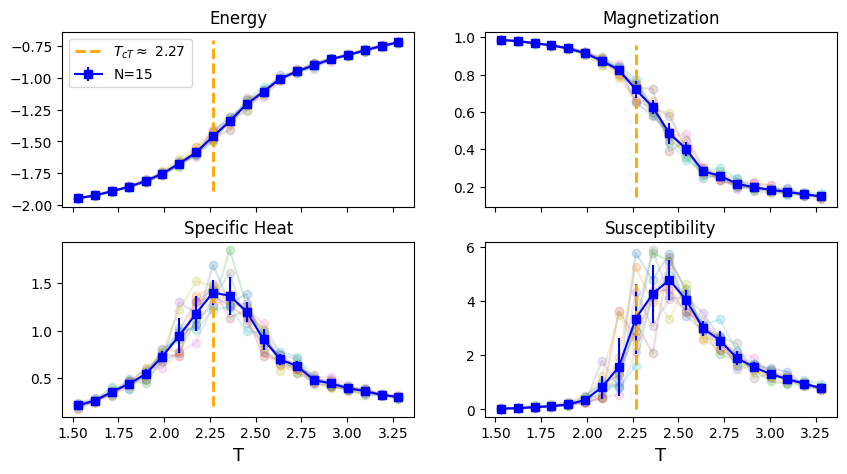

In [12]:
Plot_obs(N, E15, M15, C15, X15, len(SEEDS))

## Temperatura Crítica


In [13]:
def T_c(N, C, X):
  XLIM = (1.75,3)
  fig, ax = plt.subplots(1,2, figsize=(5*2, 5))
  TEMP = np.linspace(1.53, 3.28, NTEMP)
  TEMP2 = np.linspace(1.53, 3.28, NTEMP*100)
  C_p = np.polyfit(TEMP,C.mean(axis=1), C.shape[0])
  C_f = np.poly1d(C_p)
  X_p = np.polyfit(TEMP,X.mean(axis=1), X.shape[0])
  X_f = np.poly1d(X_p)

  ax[0].errorbar(TEMP, C.mean(axis=1), yerr=C.std(axis=1), fmt= "b-s")
  Tc_C = TEMP2[np.argmax(C_f(TEMP2))]
  ax[0].errorbar(TEMP2, C_f(TEMP2), color='red')
  ax[0].vlines(x=Tc_C, ymin=0.00001, ymax=C_f(Tc_C)*.97, linestyles='dashed', color='red', label=f'$T_c$ = {Tc_C:.2f}')
  ax[0].set_xlim(XLIM)
  ax[0].set_title("Specific Heat")


  ax[1].errorbar(TEMP, X.mean(axis=1), yerr=X.std(axis=1), fmt= "b-s")
  Tc_X = TEMP2[np.argmax(X_f(TEMP2))]
  ax[1].errorbar(TEMP2, X_f(TEMP2), color='red')
  ax[1].vlines(x=Tc_X, ymin=0.00001, ymax=X_f(Tc_X)*.97, linestyles='dashed', color='red', label=f'$T_c$ = {Tc_X:.2f}')
  ax[1].set_title("Susceptibility")
  ax[1].set_xlim(XLIM)
  ax[0].legend()
  ax[1].legend()
  ax[0].set_xlabel('T', size=13)
  ax[1].set_xlabel('T', size=13)
  plt.savefig(f'SSCr_{N}.pdf', bbox_inches = 'tight')

<ipython-input-14-3ddaad4db805>:1: RankWarning: Polyfit may be poorly conditioned
  T_c(N, C15, X15)
<ipython-input-14-3ddaad4db805>:1: RankWarning: Polyfit may be poorly conditioned
  T_c(N, C15, X15)


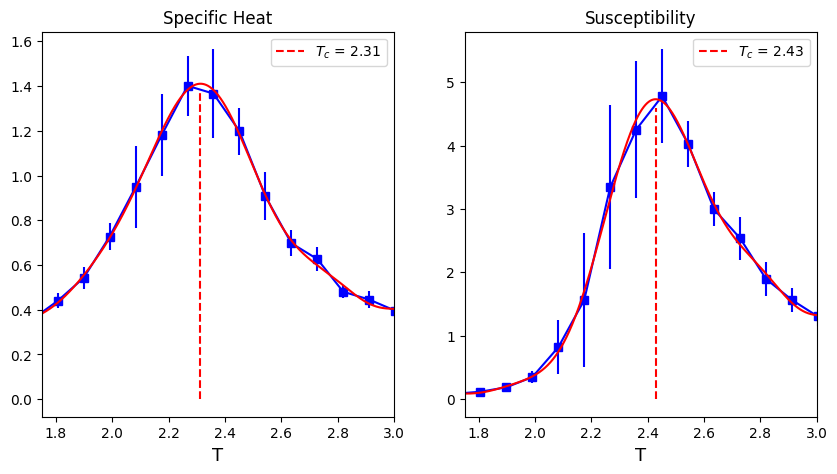

In [14]:
T_c(N, C15, X15)